In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import idx2numpy
import numpy as np
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [9]:
input_dim = 784
hidden_dim = 200
latent_dim = 20
epochs = 30
learning_rate = 0.00003
batch_size = 32

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat

def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)
        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma**2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batch_size

In [11]:
images = idx2numpy.convert_from_file('data/MNIST/raw/train-images.idx3-ubyte')  # shape: (num_images, rows, cols)
labels = idx2numpy.convert_from_file('data/MNIST/raw/train-labels.idx1-ubyte')  # shape: (num_images, rows, cols)

class mnistDataset(Dataset):
    def __init__(self, images, labels):
        self.x_data = torch.FloatTensor(images).flatten(1,-1)/255
        self.y_data = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]
        y = self.y_data[idx]

        return x, y

dataset = mnistDataset(images, labels)

dataloader = DataLoader(
    dataset, 
    batch_size = batch_size, 
    shuffle=True
)

In [12]:
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(epochs):
    loss_sum = 0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(loss_avg)

84.69135150553386
57.37240985310872
52.81755691121419
50.49097224527995
49.301939239501955
48.41262366333008
47.6882373453776
47.03064155069987
46.55618033243815
46.22456041463216
45.87499456583659
45.630762943522136
45.32975886433919
45.08477308146159
44.81694647827148
44.64132275390625
44.431385677083334
44.26382749023438
44.044441135660804
43.86610187784831
43.69131817830404
43.55609900716146
43.39096084798177
43.27957554117839
43.141308809407555
43.0413998046875
42.903462178548175
42.80256972452799
42.70894676920573
42.59281895548503


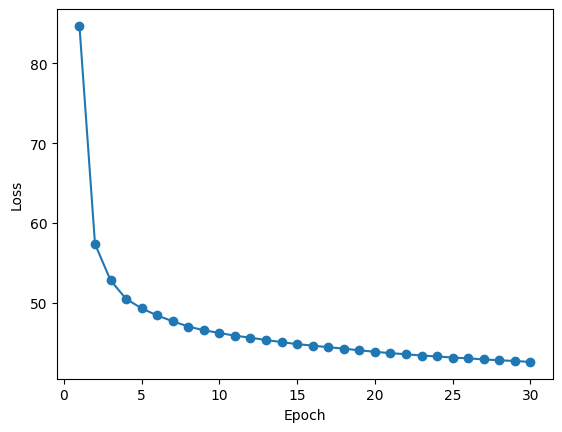

In [13]:
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

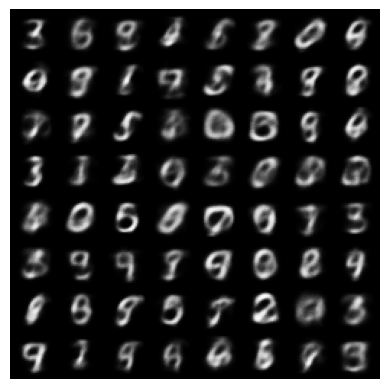

In [14]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()